# COVID-19 Pandemic Prediction 

Predicting the number of positive cases in the Philippines and also the health equipment found in hospitals (Logistic Regression). Also predict the health status of a patient using demographic characteristics (Naive Bayes).

## Imports

In [1]:
!pip install imbalanced-learn

In [1]:
##### Standard Libraries #####
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from numpy import log, dot, e
from math import sqrt
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler

##### For Building the Model #####
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
#from sklearn.pipeline import make_pipeline

##### For Validation of the Model #####
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

## Reading Data

In [3]:
df_cases = pd.read_csv('./COVID-19_Cases_in_the_Philippines_Dataset/Testing_Aggregates_20200513.csv')

In [4]:
df_cases

,Date,Name of Health Facility/Laboratory,Abbrev of Health Facility,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,% positive/ unique individuals,NEGATIVE INDIVIDUALS,% negative/ unique individuals,EQUIVOCAL,% equivocal /unique individuals,INVALID,% invalid /unique individuals,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS,Unnamed: 17
0,"April 2, 2020",Research Institute for Tropical Medicine (RITM),RITM,NaN,NaN,NaN,"15,197","2,652",17%,"11,367",75%,32,0.20%,NaN,NaN,"20,826","75,396",NaN
1,"April 2, 2020",Baguio General Hospital and Medical Center (BG...,BGHMC,NaN,NaN,NaN,473,21,4%,452,96%,0,0.00%,NaN,NaN,478,"4,519",NaN
2,"April 2, 2020",San Lazaro Hospital (SLH),SLH,NaN,NaN,NaN,115,31,27%,84,73%,0,0.00%,NaN,NaN,193,"4,846",NaN
3,"April 2, 2020",Vicente Sotto Memorial Medical Center (VSMMC),VSMMC,NaN,NaN,NaN,672,37,6%,634,94%,1,0.10%,NaN,NaN,672,"23,812",NaN
4,"April 2, 2020",UP National Institutes of Health (UP-NIH),UP-NIH,NaN,NaN,NaN,332,43,13%,279,84%,10,3.00%,NaN,NaN,335,"4,565",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,"May 12, 2020",Chinese General Hospital (CGH),CGH,22,439,439,"3,272",321,10%,"2,951",90%,0,0.00%,0.0,0.00%,"3,277",-,NaN
652,"May 12, 2020",Philippine Red Cross Logistics & Multipurpose ...,PLMC,30,"2,158","2,158","14,754",538,4%,"14,202",96%,14,0.10%,0.0,0.00%,"14,755",-,NaN
653,"May 12, 2020",Singapore Diagnostics,NaN,8,99,99,351,39,11%,312,89%,0,0.00%,0.0,0.00%,352,"9,069",NaN
654,"May 12, 2020",Lung Center of the Philippines GeneXpert Labor...,NaN,13,42,42,243,47,19%,196,81%,0,0.00%,0.0,0,243,894,NaN


In [5]:
path_isolbed_o = './COVID-19_Cases_in_the_Philippines_Dataset/DOH Data Collect - Daily Reports'
csv_isolbed_o = glob.glob(path_isolbed_o + "/*.csv")
df_list_isolbed_o = (pd.read_csv(file) for file in csv_isolbed_o)

In [6]:
df_isolbed_o = pd.concat(df_list_isolbed_o, ignore_index=True)

In [7]:
df_isolbed_o.columns

Index(['updateddate', 'addeddate', 'reportdate', 'icu_np_o', 'beds_ward_v',
       'isolbed_o', 'icu_wnp_v', 'hfhudcode', 'beds_ward_o', 'id',
       'reporttime', 'icu_np_v', 'mechvent_o', 'mechvent_v', 'isolbed_v',
       'icu_wnp_o', 'cfname', 'er_suspro', 'adm_suspro', 'er_confirm',
       'adm_confirm', 'icu_o', 'icu_v'],
      dtype='object')

In [2]:
path_surgmask = './COVID-19_Cases_in_the_Philippines_Dataset/DOH Data Collect - Weekly Reports'
csv_surgmask = glob.glob(path_surgmask + "/*.csv")
df_list_surgmask = (pd.read_csv(file) for file in csv_surgmask)

In [3]:
df_surgmask = pd.concat(df_list_surgmask, ignore_index=True)

In [4]:
df_surgmask.columns

Index(['updateddate', 'addeddate', 'reportdate', 'goggles', 'mechvent_tech',
       'icu_nurse', 'respthe', 'shoe_cover', 'pulmo', 'medtech', 'gloves',
       'face_shield', 'resident', 'gown', 'hfhudcode', 'ic_specialist',
       'n95mask', 'er_nurse', 'id_specialist', 'ward_nurse', 'id', 'surgmask',
       'head_cover', 'cfname', 'coverall'],
      dtype='object')

In [11]:
df_health_status = pd.read_csv('./COVID-19_Cases_in_the_Philippines_Dataset/Case_Information.csv')

In [12]:
df_health_status.columns

Index(['case_id', 'age', 'age_group', 'sex', 'date_announced',
       'date_recovered', 'date_of_death', 'status',
       'date_announced_as_removed', 'province', 'muni_city', 'health_status',
       'home_quarantined', 'date_of_onset_of_symptoms', 'pregnant', 'region'],
      dtype='object')

## Predict Number of Positive Cases

Use linear regression to predict the number of <i> positive individuals </i>

Steps:
1. Clean data and convert all values to int
2. Create correlation matrix and visualize it. Choose factors with high correlation to <i>POSITIVE INDIVIDUALS</i>
3. Create linear regression model and predict using x_test.
4. Compare y_pred and y_test
5. Evaluate model using R2, MSE, and RMSE


In [13]:
df_cases.columns

Index(['Date', 'Name of Health Facility/Laboratory',
       'Abbrev of Health Facility', 'Daily Output - Positive Individuals',
       'Daily Output - Unique Individuals Tested ',
       'Daily Output - Tests Conducted', 'UNIQUE INDIVIDUALS TESTED',
       'POSITIVE INDIVIDUALS', '% positive/ unique individuals',
       'NEGATIVE INDIVIDUALS', '% negative/ unique individuals', 'EQUIVOCAL',
       '% equivocal /unique individuals', 'INVALID',
       '% invalid /unique individuals', 'TOTAL TESTS CONDUCTED',
       'REMAINING AVAILABLE TESTS', 'Unnamed: 17'],
      dtype='object')

In [14]:
df_cases = df_cases.drop('Unnamed: 17', axis=1)

In [15]:
df_corr_cases = df_cases.drop(['Date', 'Name of Health Facility/Laboratory',
       'Abbrev of Health Facility', '% positive/ unique individuals', '% negative/ unique individuals', '% equivocal /unique individuals', 
        '% invalid /unique individuals'], axis=1)

In [16]:
# replace NA data with 0
df_corr_cases = df_corr_cases.fillna(0)

In [17]:
# check the types of each column
df_corr_cases.dtypes

Daily Output - Positive Individuals           object
Daily Output - Unique Individuals Tested      object
Daily Output - Tests Conducted                object
UNIQUE INDIVIDUALS TESTED                     object
POSITIVE INDIVIDUALS                          object
NEGATIVE INDIVIDUALS                          object
EQUIVOCAL                                      int64
INVALID                                      float64
TOTAL TESTS CONDUCTED                         object
REMAINING AVAILABLE TESTS                     object
dtype: object

In [18]:
# the numbers in eahc column are in string format with commas. remove commas first to convert str to int
df_corr_cases = df_corr_cases.replace(",", "", regex=True)

In [19]:
# this row has 'NR' as its values so dropped it
df_corr_cases = df_corr_cases.drop(146)

In [20]:
# some rows have '-' as their value in REMAINING AVAILABLE TESTS so replace them with 0
df_corr_cases.loc[df_corr_cases['REMAINING AVAILABLE TESTS'] == '-']

,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS,EQUIVOCAL,INVALID,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS
617,0,8,7,8,0,7,0,1.0,7,-
624,24,366,366,2833,299,2534,0,0.0,2838,-
644,0,16,17,16,0,24,0,0.0,24,-
651,22,439,439,3272,321,2951,0,0.0,3277,-
652,30,2158,2158,14754,538,14202,14,0.0,14755,-


In [21]:
df_corr_cases = df_corr_cases.replace("-", "0")

In [22]:
# now change all values in the dataframe to int
df_corr_cases = df_corr_cases.astype(int)

In [23]:
# types have now changed to int
df_corr_cases.dtypes

Daily Output - Positive Individuals          int32
Daily Output - Unique Individuals Tested     int32
Daily Output - Tests Conducted               int32
UNIQUE INDIVIDUALS TESTED                    int32
POSITIVE INDIVIDUALS                         int32
NEGATIVE INDIVIDUALS                         int32
EQUIVOCAL                                    int32
INVALID                                      int32
TOTAL TESTS CONDUCTED                        int32
REMAINING AVAILABLE TESTS                    int32
dtype: object

In [24]:
# calculate correlation values of each column with each other to find the columns we can use
df_corr_cases.corr()

,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS,EQUIVOCAL,INVALID,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS
Daily Output - Positive Individuals,1.000000,0.658014,0.671802,0.476077,0.514300,0.465780,0.251123,0.081320,0.467161,0.196757
Daily Output - Unique Individuals Tested,0.658014,1.000000,0.990812,0.644753,0.567148,0.655022,0.200055,0.064238,0.625036,0.364163
Daily Output - Tests Conducted,0.671802,0.990812,1.000000,0.701332,0.629663,0.710170,0.212423,0.067451,0.683453,0.377935
UNIQUE INDIVIDUALS TESTED,0.476077,0.644753,0.701332,1.000000,0.970181,0.998950,0.294263,0.068177,0.999053,0.596016
POSITIVE INDIVIDUALS,0.514300,0.567148,0.629663,0.970181,1.000000,0.958205,0.332230,0.059700,0.975383,0.538851
NEGATIVE INDIVIDUALS,0.465780,0.655022,0.710170,0.998950,0.958205,1.000000,0.281079,0.065034,0.996830,0.602826
EQUIVOCAL,0.251123,0.200055,0.212423,0.294263,0.332230,0.281079,1.000000,0.752341,0.290951,0.104416
INVALID,0.081320,0.064238,0.067451,0.068177,0.059700,0.065034,0.752341,1.000000,0.063102,-0.019909
TOTAL TESTS CONDUCTED,0.467161,0.625036,0.683453,0.999053,0.975383,0.996830,0.290951,0.063102,1.000000,0.598473
REMAINING AVAILABLE TESTS,0.196757,0.364163,0.377935,0.596016,0.538851,0.602826,0.104416,-0.019909,0.598473,1.000000


<AxesSubplot:>

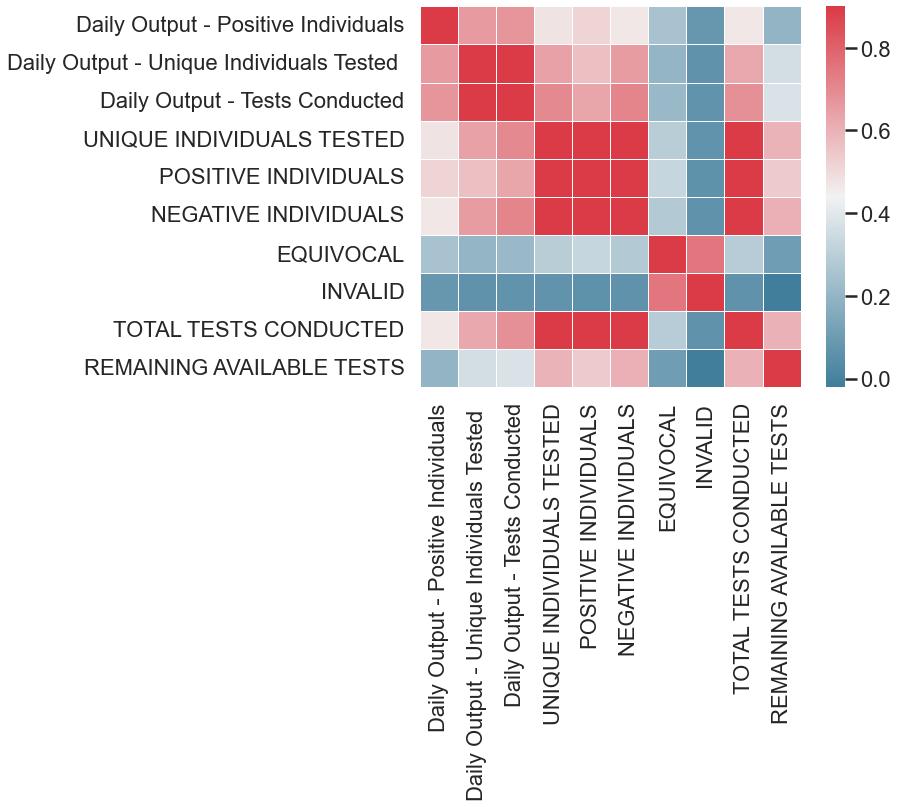

In [25]:
# Correlation heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr_cases.corr(), cmap=cmap, vmax=.9, square=True, linewidths=.5, ax=ax)

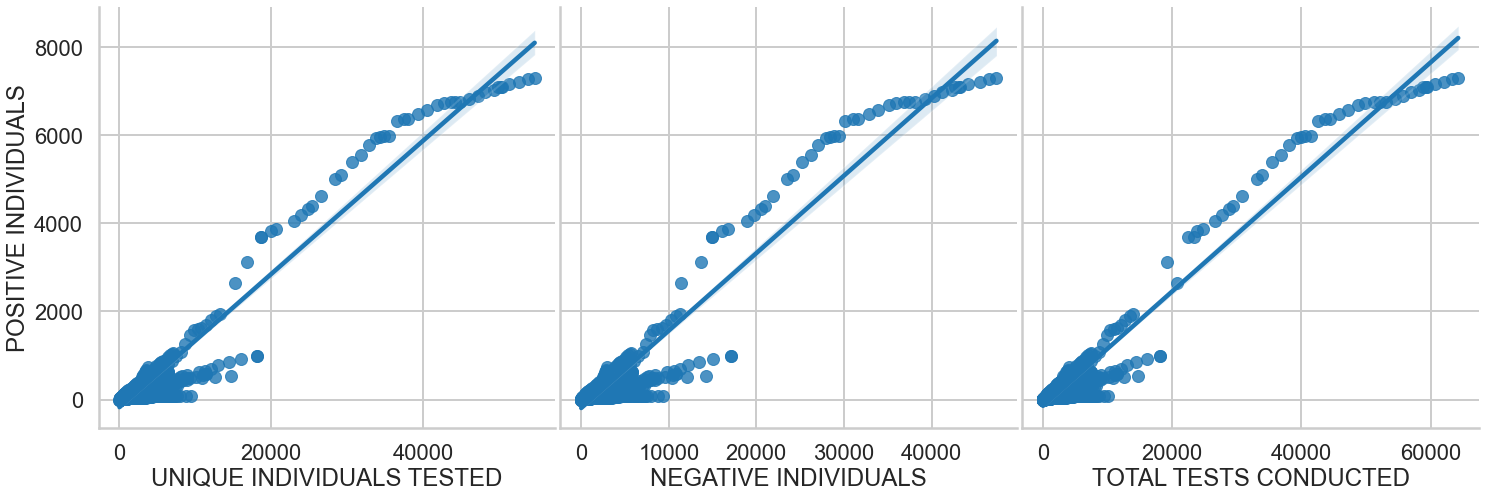

In [26]:
# visualize the relationship of the 3 predictors and positive individuals
sns.pairplot(df_corr_cases, x_vars=['UNIQUE INDIVIDUALS TESTED', 'NEGATIVE INDIVIDUALS', 'TOTAL TESTS CONDUCTED'], y_vars='POSITIVE INDIVIDUALS', height=7,aspect=1,kind='reg')

To predict the number positive individuals, we will use the predictors that scored over 90% on the correlation matrix which are: unique individuals tested, negative individuals, and total tests conducted.

In [27]:
x = df_corr_cases[['UNIQUE INDIVIDUALS TESTED', 'NEGATIVE INDIVIDUALS', 'TOTAL TESTS CONDUCTED']]
x.head(5)

,UNIQUE INDIVIDUALS TESTED,NEGATIVE INDIVIDUALS,TOTAL TESTS CONDUCTED
0,15197,11367,20826
1,473,452,478
2,115,84,193
3,672,634,672
4,332,279,335


In [28]:
y = df_corr_cases['POSITIVE INDIVIDUALS']
y.head(5)

0    2652
1      21
2      31
3      37
4      43
Name: POSITIVE INDIVIDUALS, dtype: int32

In [29]:
# separate into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

In [30]:
# make and fit linear regression model
model = LinearRegression().fit(x_train, y_train)

In [31]:
# predictions by the model
y_pred = model.predict(x_test)

In [32]:
# intercept
model.intercept_

-6.084578183810208

In [33]:
# coefficients
model.coef_

array([ 0.94246098, -0.96600027,  0.02393471])

In [34]:
# coefficient of determination (r2)
model.score(x_test, y_test)

0.9937439536444714

In [35]:
MSE = mean_squared_error(y_pred, y_test)
MSE

15656.563171926233

In [36]:
RMSE = sqrt(MSE)
RMSE

125.12618899305706

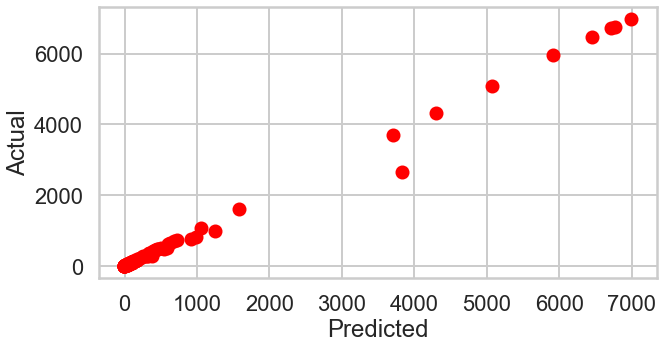

In [37]:
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, y_test, color ='r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

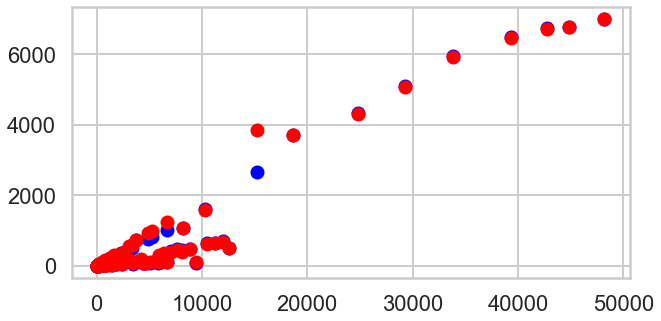

In [38]:
# plot of y_test with unique individuals test (b) vs y_pred with unique individuals test (r)
plt.figure(figsize=(10, 5))
plt.scatter(x_test['UNIQUE INDIVIDUALS TESTED'], y_test, color ='b')
plt.scatter(x_test['UNIQUE INDIVIDUALS TESTED'], y_pred, color ='r')
#plt.plot(y_pred, color ='k')
  
plt.show()

<b>Model: </b> -6.086 + 0.942(Unique Individuals Tested) - 0.966(Negative Individuals) + 0.024(Total Tests Conducted) 


The model was able to get 99.4% as the coefficient of determination score. The MSE of the model is 15656.56 and the RMSE is 125.13.

note: values change every run of this notebook

## Predict Number of Isolation Beds - Benjie
- use logistic regression to predict number of isolation beds
- choose which factors strongly affect isolbed_o and use thos in the regression 

## Predict Number of Surgical Masks - Pam
- use logistic regression to predict number of isolation beds
- choose which factors strongly affect isolbed_o and use thos in the regression 

In [18]:
df_surgmask.columns

Index(['updateddate', 'addeddate', 'reportdate', 'goggles', 'mechvent_tech',
       'icu_nurse', 'respthe', 'shoe_cover', 'pulmo', 'medtech', 'gloves',
       'face_shield', 'resident', 'gown', 'hfhudcode', 'ic_specialist',
       'n95mask', 'er_nurse', 'id_specialist', 'ward_nurse', 'id', 'surgmask',
       'head_cover', 'cfname', 'coverall'],
      dtype='object')

In [19]:
df_corr_surgmask = df_surgmask.drop(['updateddate', 'addeddate','reportdate', 'hfhudcode','id','cfname', 'ic_specialist'], axis=1)

In [20]:
# replace NA data with 0
df_corr_surgmask = df_corr_surgmask.fillna(0)

In [21]:
df_corr_surgmask.dtypes

goggles            int64
mechvent_tech    float64
icu_nurse        float64
respthe          float64
shoe_cover         int64
pulmo            float64
medtech          float64
gloves             int64
face_shield        int64
resident         float64
gown               int64
n95mask            int64
er_nurse         float64
id_specialist    float64
ward_nurse        object
surgmask           int64
head_cover         int64
coverall         float64
dtype: object

In [22]:
# calculate the correlation
df_corr_surgmask.corr()

,goggles,mechvent_tech,icu_nurse,respthe,shoe_cover,pulmo,medtech,gloves,face_shield,resident,gown,n95mask,er_nurse,id_specialist,surgmask,head_cover,coverall
goggles,1.000000,0.002281,0.110391,0.072018,0.620708,0.035201,0.135892,0.430278,0.774090,0.035234,0.289205,0.343275,0.117407,0.087156,0.432796,0.280481,0.744519
mechvent_tech,0.002281,1.000000,0.458635,0.552305,0.019530,0.469743,0.372136,-0.003397,0.001506,0.647545,0.002559,-0.003690,0.430137,0.396681,-0.005699,0.014331,-0.006729
icu_nurse,0.110391,0.458635,1.000000,0.735714,0.070097,0.553976,0.871828,-0.002108,0.008550,0.696207,0.019311,-0.002573,0.838956,0.691521,-0.004530,0.037436,-0.007645
respthe,0.072018,0.552305,0.735714,1.000000,0.069204,0.609806,0.682610,-0.003642,0.016402,0.711506,0.013922,-0.000986,0.713228,0.658144,-0.005827,0.034765,-0.009206
shoe_cover,0.620708,0.019530,0.070097,0.069204,1.000000,0.028846,0.085283,0.377642,0.568396,0.039881,0.547846,0.258945,0.073539,0.059721,0.636049,0.392300,0.751561
pulmo,0.035201,0.469743,0.553976,0.609806,0.028846,1.000000,0.546137,-0.003184,0.000993,0.527520,0.006849,-0.007980,0.581474,0.737734,-0.010489,0.016626,-0.013248
medtech,0.135892,0.372136,0.871828,0.682610,0.085283,0.546137,1.000000,-0.003498,0.009878,0.617713,0.021133,-0.005758,0.918129,0.722005,-0.007080,0.046475,-0.010442
gloves,0.430278,-0.003397,-0.002108,-0.003642,0.377642,-0.003184,-0.003498,1.000000,0.370313,-0.004058,0.060622,0.114310,-0.004540,-0.002474,0.229852,0.156701,0.384221
face_shield,0.774090,0.001506,0.008550,0.016402,0.568396,0.000993,0.009878,0.370313,1.000000,0.005000,0.393460,0.486145,0.006480,0.007995,0.536258,0.350665,0.765327
resident,0.035234,0.647545,0.696207,0.711506,0.039881,0.527520,0.617713,-0.004058,0.005000,1.000000,0.006725,-0.005007,0.699097,0.533581,-0.008346,0.013525,-0.010679


<AxesSubplot:>

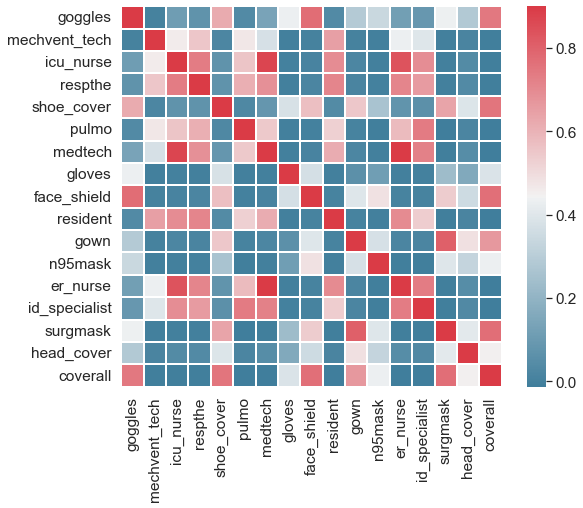

In [28]:
# Correlation heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr_surgmask.corr(), cmap=cmap, vmax=.9, square=True, linewidths=.3, ax=ax)

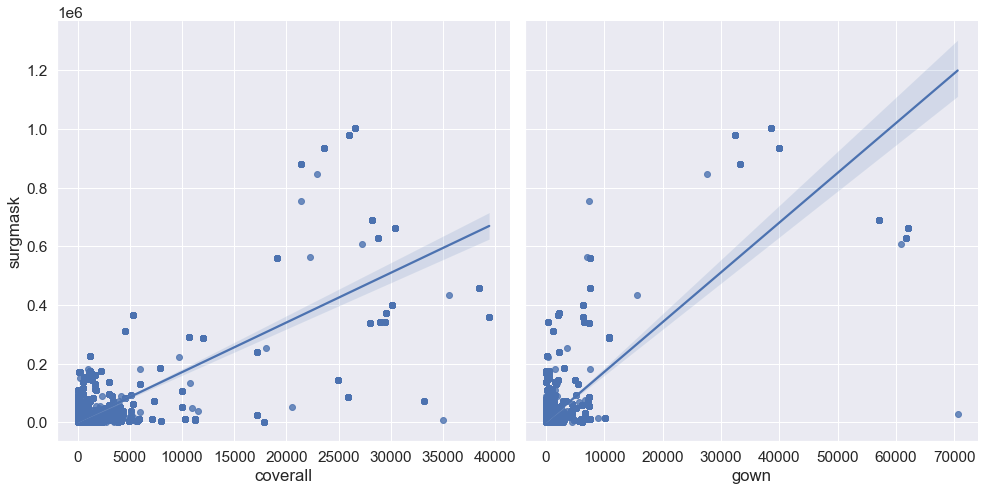

In [29]:
# visualize the relationship of the 2 predictors and surgical mask
sns.pairplot(df_corr_surgmask, x_vars=['coverall', 'gown'], y_vars='surgmask', height=7,aspect=1,kind='reg')

In [30]:
x = df_corr_surgmask[['coverall', 'gown']]
y = df_corr_surgmask['surgmask']

In [31]:
# separate into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

In [32]:
model = LinearRegression().fit(x_train, y_train)

In [33]:
# predictions by the model
y_pred = model.predict(x_test)

In [34]:
# intercept
model.intercept_

643.2163843889548

In [35]:
# coefficients
model.coef_

array([ 9.06584516, 10.76388142])

In [37]:
# coefficient of determination (r2)
model.score(x_test, y_test)

0.7702231811913512

In [38]:
MSE = mean_squared_error(y_pred, y_test)
MSE

431969619.05519444

In [39]:
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
RMSE

20783.878826032316

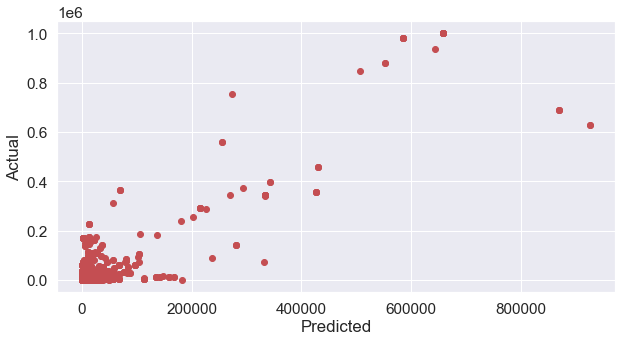

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, y_test, color ='r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

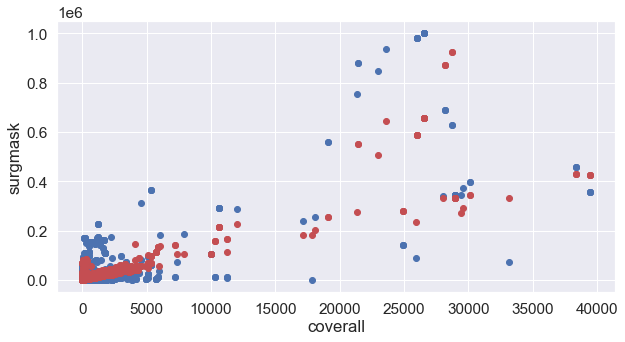

In [44]:
# comparing y test and y pred with coverall
plt.figure(figsize=(10, 5))
plt.scatter(x_test['coverall'], y_test, color ='b')
plt.scatter(x_test['coverall'], y_pred, color ='r')
plt.xlabel('coverall')
plt.ylabel('surgmask')
  
plt.show()

<b>model: </b> y = 643.22 + 9.06584516(coverall) + 10.76388142(gown)

The model scored a coefficient of determination score of 0.77, an MSE score of 431969619.05519444, and an RMSE score of 20783.878826032316. The large MSE and RMSE score can be attributed to the large variability in the data values.

## Predict Health Status of Individual 
- use Gaussian Naive Bayes classifier to classify if an individual's health status is Mild (0), Recovered (1), Asymptomatic (2), Died (3), Severe (4), or Critical (5)
- features to be used are: age, sex, home_quarantined, pregnant

Steps:
1. Separate data into features and label, clean, then encode
        1.1 Balance data using SMOTENN
2. Create the multinomial classifier and fit using x_train and y_train
3. Predict
4. Evaluate

In [40]:
df_health_status.columns

Index(['case_id', 'age', 'age_group', 'sex', 'date_announced',
       'date_recovered', 'date_of_death', 'status',
       'date_announced_as_removed', 'province', 'muni_city', 'health_status',
       'home_quarantined', 'date_of_onset_of_symptoms', 'pregnant', 'region'],
      dtype='object')

In [41]:
# we have 6 classes biased towards Mild class
df_health_status.health_status.value_counts()

Mild            7777
Recovered       2460
Asymptomatic     969
Died             806
Severe            54
Critical          25
Name: health_status, dtype: int64

In [42]:
df_health_status.head(3)

,case_id,age,age_group,sex,date_announced,date_recovered,date_of_death,status,date_announced_as_removed,province,muni_city,health_status,home_quarantined,date_of_onset_of_symptoms,pregnant,region
0,C404174,38.0,35 to 39,Female,2020-01-30,NaN,NaN,Recovered,2020-02-07,Negros Oriental,Dumaguete City,Recovered,NaN,2020-01-21,NaN,Central Visayas (Region VII)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaN,2020-02-01,Died,2020-02-02,Negros Oriental,Dumaguete City,Died,NaN,2020-01-18,NaN,Central Visayas (Region VII)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaN,Recovered,2020-02-05,Bohol,Panglao,Recovered,No,2020-01-21,NaN,Central Visayas (Region VII)


In [43]:
features = df_health_status[['age', 'sex', 'home_quarantined', 'pregnant']]
label = df_health_status['health_status']

In [44]:
# replace NaN values with unknown
features = features.fillna("Unknown")
features

,age,sex,home_quarantined,pregnant
0,38.0,Female,Unknown,Unknown
1,44.0,Male,Unknown,Unknown
2,60.0,Female,No,Unknown
3,48.0,Male,No,Unknown
4,62.0,Male,No,Unknown
...,...,...,...,...
12086,35.0,Male,Unknown,Unknown
12087,37.0,Male,Unknown,Unknown
12088,62.0,Female,Unknown,Unknown
12089,18.0,Female,Yes,No


In [45]:
# replace unkown ages with 0
features.age = features.age.replace(["Unknown"], 0)

In [46]:
# encoding strings into numerical
le = preprocessing.LabelEncoder()
features.sex = le.fit_transform(features.sex)  # female = 0, male = 1
features.home_quarantined = le.fit_transform(features.home_quarantined) # Unknown = 1, No = 0, Yes = 2
features.pregnant = le.fit_transform(features.pregnant) # Unknown = 1, No = 0, Yes = 2

In [47]:
features

,age,sex,home_quarantined,pregnant
0,38.0,0,1,1
1,44.0,1,1,1
2,60.0,0,0,1
3,48.0,1,0,1
4,62.0,1,0,1
...,...,...,...,...
12086,35.0,1,1,1
12087,37.0,1,1,1
12088,62.0,0,1,1
12089,18.0,0,2,0


In [48]:
# split data into trianing and testing
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.15)

In [49]:
x_train

,age,sex,home_quarantined,pregnant
9886,65.0,0,1,1
6633,27.0,1,1,1
7048,54.0,1,1,1
3213,42.0,0,1,0
10921,84.0,0,1,1
...,...,...,...,...
8671,52.0,1,1,1
7937,50.0,0,1,1
11558,52.0,1,1,1
390,53.0,1,0,1


In [50]:
model_nb = GaussianNB().fit(x_train, y_train)

In [51]:
y_pred_nb = model_nb.predict(x_test)
y_pred_nb

array(['Mild', 'Recovered', 'Mild', ..., 'Mild', 'Mild', 'Mild'],
      dtype='<U12')

In [52]:
accuracy_score(y_test, y_pred_nb)

0.6328555678059536

In [53]:
# all scores are the same
precision_recall_fscore_support(y_test, y_pred_nb, average='micro')

(0.6328555678059536, 0.6328555678059536, 0.6328555678059536, None)

In [54]:
cm = confusion_matrix(y_test, y_pred_nb, labels=["Mild", "Recovered", "Asymptomatic", "Died", "Severe", "Critical"])
cm

array([[1039,   90,   16,   33,    0,    0],
       [ 249,   65,   36,   19,    0,    0],
       [  93,   26,   20,    2,    0,    0],
       [  79,   12,    0,   24,    0,    0],
       [   6,    1,    0,    0,    0,    0],
       [   3,    0,    0,    1,    0,    0]], dtype=int64)

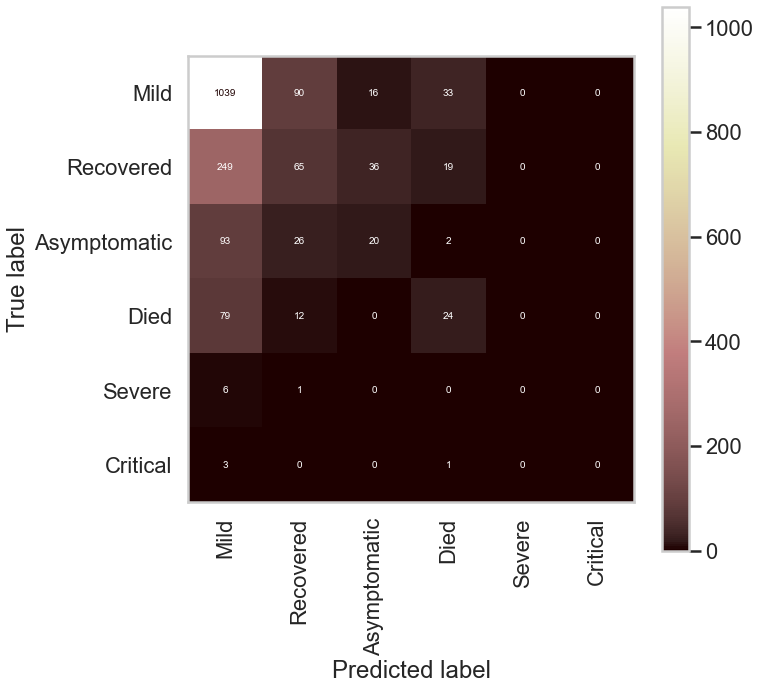

In [55]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mild", "Recovered", "Asymptomatic", "Died", "Severe", "Critical"])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
display.plot(ax=ax, xticks_rotation="vertical", cmap="pink")

Since the performance metrics values are low, we will try to create a classifier by using age_group instead of age.

In [56]:
# if using age groups
features_2 = df_health_status[['age_group', 'sex', 'home_quarantined', 'pregnant']]
features_2 = features_2.fillna("Unknown")
features_2.age_group = features_2.age_group.replace(["Unknown"], "0")

features_2.age_group = le.fit_transform(features_2.age_group)
features_2.sex = le.fit_transform(features_2.sex)  # female = 0, male = 1
features_2.home_quarantined = le.fit_transform(features_2.home_quarantined) # Unknown = 1, No = 0, Yes = 2
features_2.pregnant = le.fit_transform(features_2.pregnant) # Unknown = 1, No = 0, Yes = 2

# split data into trianing and testing
x_train1, x_test1, y_train1, y_test1 = train_test_split(features, label, test_size = 0.15)

In [57]:
new_model = GaussianNB().fit(x_train1, y_train1)

In [58]:
new_y_pred = new_model.predict(x_test1)
accuracy_score(y_test1, new_y_pred)

0.6058434399117971

In [59]:
precision_recall_fscore_support(y_test1, new_y_pred, average='micro')

(0.6058434399117971, 0.6058434399117971, 0.6058434399117971, None)

Grouping the individuals by age doesn't improve the model by much, so we will stick with separating the individuals by their exact age and try to balance the dataset using SMOTENN.

In [71]:
smote_enn = SMOTEENN(sampling_strategy='not majority', random_state=0)
x_resampled, y_resampled = smote_enn.fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Asymptomatic', 1234), ('Critical', 5181), ('Died', 1619), ('Mild', 3659), ('Recovered', 695), ('Severe', 5207)]


In [72]:
sampled_model = GaussianNB().fit(x_resampled, y_resampled)

In [73]:
sampled_y_pred = sampled_model.predict(x_test)

In [74]:
accuracy_score(y_test, sampled_y_pred)

0.5242557883131201

In [75]:
precision_recall_fscore_support(y_test, sampled_y_pred, average="micro")

(0.5242557883131201, 0.5242557883131201, 0.5242557883131201, None)

Even over- and under- sampling the data produces lower performance metrics.